# Setup

In [33]:
import nltk
import time
import re
import numpy as np
import pandas as pd
import twint
import json
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools FOR TOPIC MODELING
import pyLDAvis
import pyLDAvis.gensim  # don't skip this


# Enable logging for gensim - optional  (I HAVEN'T USED THIS YET)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


# NLTK Stop words -------------- ADD TO THESE AS WE SEE FIT
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import pickle

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# TWINT SCRAPING FROM TWITTER 

---

SEE https://github.com/twintproject/twint for options. The following cell returns a .csv file from all tweets containing 'Coronavirs' since the time specified by the [--since] option, in the [--lang] of english (en), and the csv file gets named after whatever iteration of scraping it is plus useful search parameters in the file name.


---

In [34]:
# THE TWINT COMMAND I USE IN TERMINAL TO SCRAPE

# twint -s Coronavirus --since "2020-03-24 20:00:00" --lang en -o just_cv_en_2 --csv

# Importing and Prepocessing 

---

**Open the corpus_pipeline to make changes, I'm sure there's lots of ways to clean tweets beyond simply regexing for emails and new line characters, probably way more preprocessing we can do, especially with .extending the stopwords.**

---

In [36]:
df3 = pd.read_csv('./just_cv/twint_3_en.csv')

In [37]:
df3.shape

(14400, 34)

In [38]:
df4 = pd.read_csv('./just_cv/twint_4_en.csv')

In [39]:
df4.shape

(14399, 34)

In [40]:
df5 = pd.read_csv('./just_cv/twint_5_en.csv')

In [41]:
df5.shape

(14399, 34)

In [42]:
df6 = pd.read_csv('./just_cv/twint_6_en.csv')

In [43]:
df6.shape

(14399, 34)

In [44]:
data3 = df3.tweet.values

In [45]:
data4 = df4.tweet.values

In [46]:
data5 = df5.tweet.values

In [47]:
data6 = df6.tweet.values

In [48]:
data = np.concatenate([data3, data4, data5, data6])

In [49]:
data.shape

(57597,)

In [50]:
data[:5]

array(['I said they are better than nothing, not that they are as good as the medical ones. There was no "bare face" group to fully show how effective the cloth masks are. The cloth masks are not meant to protect you from coronavirus, they are there to catch at least some of the 1/2',
       'Oops: CNN Forgot To Translate Its Latest Coronavirus Update From Mandarin |   https://babylonbee.com/news/cnn-embarassed-after-forgetting-to-translate-latest-coronavirus-update-from-mandarin-before-publishing\xa0…',
       'Speeding up https://twitter.com/ryanfiredragon/status/1242886374963007493\xa0…',
       ...,
       'Now that the Coronavirus Act is live, here are the links to the newly amended notices. In use from today  https://twitter.com/seccles74/status/1243161076394532865\xa0…',
       'Countries ranked for most cumulative cases of Coronavirus: \n\nChina 81,218\nItaly 74,386\nUSA 68,211\nSpain 49,515\nGermany 37,323\nIran 27,017\nFrance 25,233\nSwitzerland 10,897\nUK 9,529\nS. Korea 9,1

In [51]:
types = []
for i in data:
    types.append(type(i))

In [52]:
index = 0
non_str = {}
fake = []
for i in data: 
    if type(i) != str:
        non_str[index] = type(i)
    index += 1

In [53]:
for i in non_str:
    data = np.delete(data, i)

In [54]:
df = pd.DataFrame()

df['tweets'] = data

In [55]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

df['sentiment'] = [analyser.polarity_scores(i) for i in df['tweets']]

df['compound_sentiment'] = [i['compound'] for i in df['sentiment']]
df['sentiment'] = df['compound_sentiment']
df.drop(columns=['compound_sentiment'], inplace=True)

In [56]:
filtered_sentiment_df = df.loc[(df['sentiment'] < -.40) ^ (df['sentiment'] > .40)]

In [57]:
data = filtered_sentiment_df.tweets.values

In [58]:
more = ["news","case","make","would","death","spread","story","still","stop","kill","com", "twitter","pic","say","https"]
more2 = ["help","work","time","new","covid","get","test","day","http","country","good","world","may","government","pat", 'virus']
more3 = ["due","stay","be","report","worker","bill","back","first","people","corona", 'saying', 'getting', 'pandemic', 'state', 'china', 'covid19']
more4 = ["go","die","take","see","know","status","call",'Go','Say', 'www', 'many', 'see', 'make', 'want', 'be', 'could', "s", 'tell', 'today']
more5 = ['Let', 'being', 'going','case', 'make', 'also', 'let', 'coronavirus', 'Coronavirus', 'Corona', 'must', 'much', 'thing', 'keep', 'even']
more6 = ['need', 'like', 'one', 'thank', 'html', 'covid2019', 'getting', 'making', 'coming', 'saying']


In [59]:
more.extend(more2)

In [60]:
more.extend(more3)

In [61]:
more.extend(more4)

In [62]:
more.extend(more5)

In [63]:
more.extend(more6)

In [64]:
stop_words = stopwords.words('english')

In [65]:
len(more)

91

In [66]:
len(stop_words)

179

In [67]:
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [68]:
stop_words.extend(more)

In [69]:
len(stop_words)

275

**The following returns the [id2word] dictionary, [texts] which is the lemmatized data, and [corpus] which is the corpus.**

In [71]:
def corpus_pipeline(data):  
    # ********    THE FOLLOWING REGEXES SHOULD PROBABLY BE HEAVILY MODIFIED FOR CUSTOMIZING TWEETS CLEANING  *************
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    data_words = list(sent_to_words(data))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # **********   ALSO PROBABLY REQUIRES EXTENSIVE ADDING OF TWEET-SPECIFIC STOPWORDS   ***********
    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    
    data_words_trigrams = make_trigrams(data_words_bigrams)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return id2word, texts, corpus

# Pipeline for Dict, Texts, Corpus

In [72]:
id2word, texts, corpus = corpus_pipeline(data)

**Visualizing the Tweet distribution.**

In [73]:
lendist = []
for i in texts:
    lendist.append(len(i))

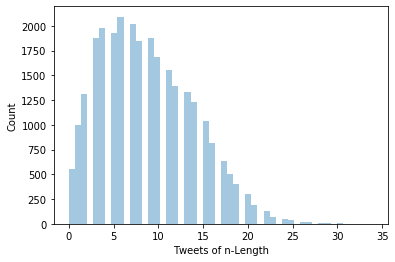

In [74]:
sns.distplot(lendist, kde=False, )
plt.ylabel('Count')
plt.xlabel('Tweets of n-Length')
plt.show()

In [75]:
tweet_total = pd.DataFrame()

In [76]:
tweet_total['tweet_lengths'] = lendist

In [77]:
tweet_total.tweet_lengths.describe()

count    27890.000000
mean         8.763715
std          5.212880
min          0.000000
25%          5.000000
50%          8.000000
75%         12.000000
max         34.000000
Name: tweet_lengths, dtype: float64

# LDA Model

In [79]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [80]:
lda_model.show_topics()

[(0,
  '0.021*"case" + 0.020*"give" + 0.017*"die" + 0.016*"update" + 0.014*"try" + 0.013*"live" + 0.012*"number" + 0.010*"hope" + 0.010*"check" + 0.010*"start"'),
 (1,
  '0.020*"outbreak" + 0.013*"lockdown" + 0.012*"fight" + 0.012*"hospital" + 0.012*"article" + 0.011*"think" + 0.010*"get" + 0.010*"job" + 0.010*"watch" + 0.010*"way"'),
 (2,
  '0.029*"sign" + 0.027*"boris_johnson_demand" + 0.025*"say" + 0.018*"event" + 0.018*"petition" + 0.017*"health" + 0.014*"care" + 0.014*"s" + 0.013*"take" + 0.013*"family"'),
 (3,
  '0.023*"home" + 0.017*"support" + 0.015*"be" + 0.015*"business" + 0.013*"safe" + 0.012*"nurse" + 0.011*"week" + 0.010*"show" + 0.010*"come" + 0.010*"work"'),
 (4,
  '0.027*"crisis" + 0.025*"trump" + 0.022*"tackle" + 0.016*"fear" + 0.014*"death" + 0.013*"relief" + 0.010*"video" + 0.010*"free" + 0.009*"really" + 0.009*"money"')]

In [82]:
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

# Topic Assignment to Original Tweets

In [83]:
final_topics = []
for i in corpus:  
    topics = lda_model.get_document_topics(i)

    probs = {}
    for i in topics:
        probs[i[0]] = i[1]

    topic = max(probs, key=probs.get)
    final_topics.append(topic)

In [84]:
len(final_topics)

27890

In [85]:
df_final = filtered_sentiment_df.copy()

In [86]:
df_final['topic'] = final_topics

In [87]:
topic_dict = {0: 'economy',
              1: 'public_health',
              2: 'boris',
              3: 'employment',
              4: 'trump'}

In [88]:
df_final['topic_defined'] = df_final.topic.apply(lambda x: topic_dict[x])

In [100]:
df_final.head()

,tweets,sentiment,topic,topic_defined
0,"I said they are better than nothing, not that ...",0.6984,4,trump
3,"Texas Gov. Greg Abbott, who routinely overrule...",0.6369,3,employment
4,"Other than Satan, is there anyone more evil th...",-0.6901,1,public_health
5,Doctors say vitamin D3 may be helpful in comba...,0.6124,4,trump
6,JUST IN: COVID-19: Edo Speaker tests positive ...,0.5574,1,public_health


In [91]:
df_final.groupby('topic_defined')['sentiment'].describe()

,count,mean,std,min,25%,50%,75%,max
topic_defined,,,,,,,,
boris,2081.0,-0.004741,0.641610,-0.9874,-0.6249,0.4019,0.557400,0.9862
economy,1824.0,-0.128242,0.639244,-0.9902,-0.6597,-0.4823,0.556500,0.9752
employment,5945.0,0.058552,0.651989,-0.9935,-0.5994,0.4215,0.647600,0.9823
public_health,13186.0,-0.063495,0.645915,-0.9842,-0.6369,-0.4404,0.557400,0.9928
trump,4854.0,0.020076,0.667711,-0.9913,-0.6249,0.4019,0.646325,0.9920


## Trump Cluster

In [111]:
trump = df_final.loc[(df_final.topic_defined == 'trump')]

worst5vals = sorted(trump.sentiment)[10]

trump_worst_5 = trump.loc[trump.sentiment < worst5vals]

best5vals = sorted(trump.sentiment, reverse=True)[30]

trump_best_5 = trump.loc[trump.sentiment > best5vals]

## Boris Cluster

In [112]:
boris = df_final.loc[(df_final.topic_defined == 'boris')]

worst30vals = sorted(boris.sentiment)[30]

boris_worst_30 = boris.loc[boris.sentiment < worst30vals]

best30vals = sorted(boris.sentiment, reverse=True)[30]

boris_best_30 = boris.loc[boris.sentiment > best30vals]

## Economy Cluster

In [113]:
economy = df_final.loc[(df_final.topic_defined == 'economy')]

worst30vals = sorted(economy.sentiment)[30]

economy_worst_30 = economy.loc[economy.sentiment < worst30vals]

best30vals = sorted(economy.sentiment, reverse=True)[30]

economy_best_30 = economy.loc[economy.sentiment > best30vals]

## Public Health Cluster

In [114]:
ph = df_final.loc[(df_final.topic_defined == 'public_health')]

worst30vals = sorted(ph.sentiment)[30]

ph_worst_30 = ph.loc[ph.sentiment < worst30vals]

best30vals = sorted(ph.sentiment, reverse=True)[30]

ph_best_30 = ph.loc[ph.sentiment > best30vals]

## Employment Cluster

In [115]:
emp = df_final.loc[(df_final.topic_defined == 'employment')]

worst30vals = sorted(emp.sentiment)[30]

emp_worst_30 = emp.loc[emp.sentiment < worst30vals]

best100vals = sorted(emp.sentiment, reverse=True)[100]

emp_best_100 = emp.loc[emp.sentiment > best100vals]

# Visualizing and Findings

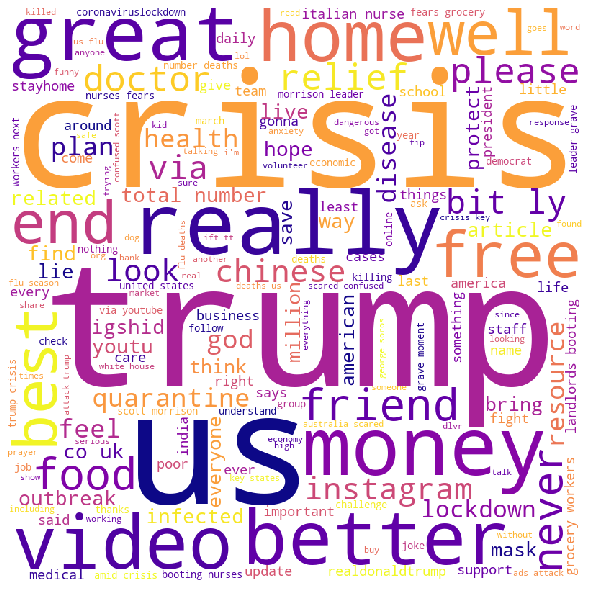

In [106]:

comment_words = ' '
stopwords = stop_words
  
# iterate through the csv file 
for val in trump.tweets: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                colormap = 'plasma').generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

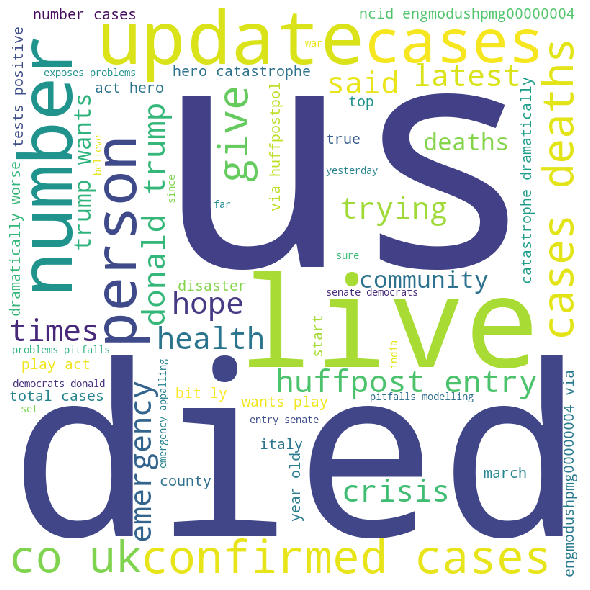

In [109]:

comment_words = ' '
stopwords = stop_words 
  
# iterate through the csv file 
for val in economy.tweets: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [116]:
comment_words = []
stopwords = stop_words 
  
# iterate through the csv file 
for val in boris.tweets.values: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      

    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    
    for words in tokens: 
        comment_words.append(words)
  

In [117]:
boris_fix = ' '.join(comment_words)

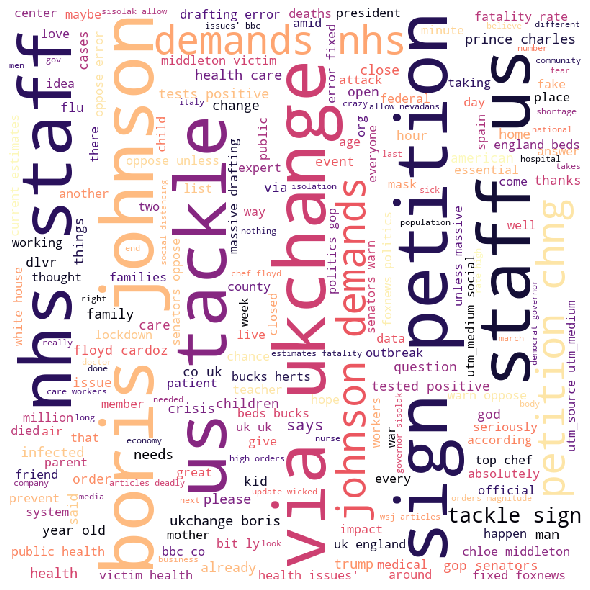

In [118]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                colormap='magma').generate(boris_fix) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [119]:
boris.tweets

24       WASHING YOUR HANDS IS GOOD BUT IS IT ENOUGH TO...
40       Oh and by the way, and I know you will say thi...
42       At this point, y’all can’t even be mad at Trum...
73       #5G technology has been alleged to cause illne...
106      A "Safer-at-Home" mandate has been issued for ...
                               ...                        
57472    Boris Johnson: 6 Demands from NHS staff to hel...
57501    Why Did God Allow the Coronavirus?: Biblical A...
57517    Boris Johnson: 6 Demands from NHS staff to hel...
57564    Trump sends cease, desist letter on ad featuri...
57568    Gov. Charlie Baker is ordering schools & non-e...
Name: tweets, Length: 2081, dtype: object

In [120]:
comment_words = []
stopwords = stop_words 
  
# iterate through the csv file 
for val in ph.tweets.values: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      

    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    
    for words in tokens: 
        comment_words.append(words)
  

In [121]:
ph_fix = ' '.join(comment_words)

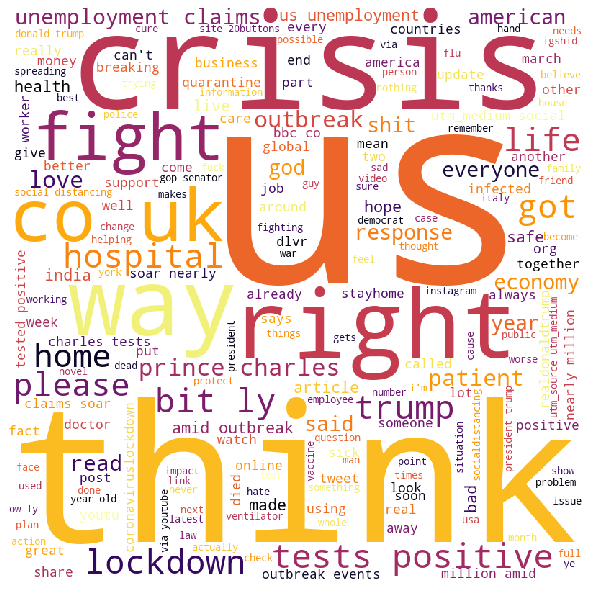

In [122]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                colormap = 'inferno').generate(ph_fix) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [125]:
comment_words = []
stopwords = stop_words 
  
# iterate through the csv file 
for val in emp.tweets.values: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      

    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    
    for words in tokens: 
        comment_words.append(words)
  

In [126]:
emp_fix = ' '.join(comment_words)

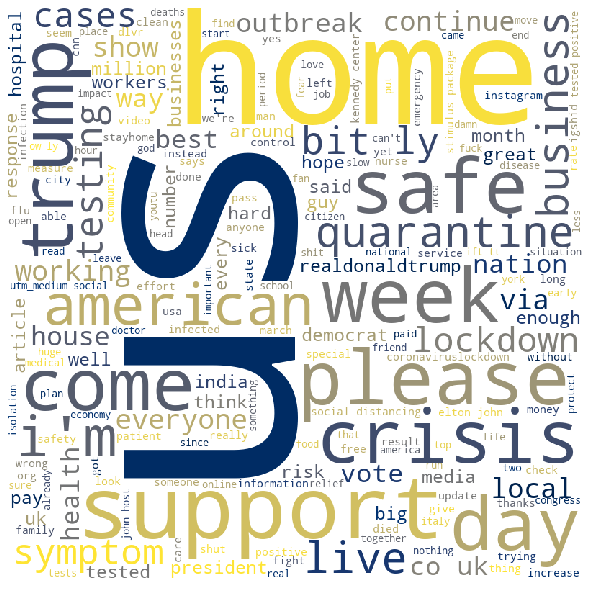

In [128]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                colormap = 'cividis').generate(emp_fix) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Experimental Day-Of

In [129]:
boris_tweets = pd.read_csv('boris_tweets.csv')

**The following was simply an experimental wordcloud created from 15,000 tweets on Friday, March 27th around 10:00 AM, shortly after it was revealed that Boris Johnson tested positive for COVID-19.** 

In [130]:
comment_words = []
stopwords = stop_words 
  
# iterate through the csv file 
for val in boris_tweets.tweet.values: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      

    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    
    for words in tokens: 
        comment_words.append(words)
  

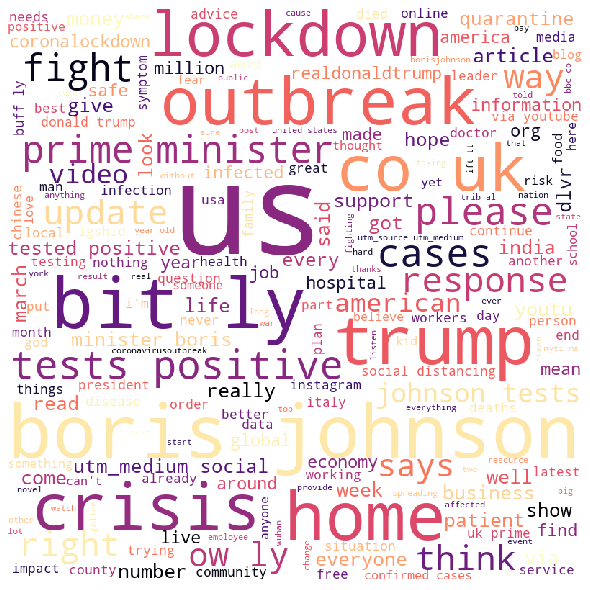

In [131]:
boris_tweets_fix = ' '.join(comment_words)

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                colormap='magma').generate(boris_tweets_fix) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Pickle

In [132]:
# pickle.dump(lda_model, open("lda_5_3456_best", "wb" ))

In [133]:
# pickle.dump(corpus, open("corpus_best", "wb" ))

In [ ]:
# pickle.dump(id2word, open("id2word_best", "wb" ))

In [ ]:
# pickle.dump(texts, open("texts_best", "wb" ))

In [2]:
lda_model = pickle.load( open( "lda_5_3456_best", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d

In [3]:
corpus = pickle.load( open( "corpus_best", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d

In [4]:
id2word = pickle.load( open( "id2word_best", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d

In [5]:
texts = pickle.load( open( "texts_best", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d